## Summary of data
## Properties from San Jose, CA
## 6099 condos
## 92 different neighborhoods

In [129]:
PROPERTY_TYPES = ['condo', 'townhouse', 'multiunit', 'singlefamily']
TRESH = 0.15
NUM_BINS = 5
BINS = []

MONTHS = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 
          'Jun', 'Jul', 'Aug', 'Sep', 'Oct',
         'Nov', 'Dec']

COLS_EXCLUDE = ['Median Sale Price','Region','neighborhood',
                'location','city','property_type','state',
                'Month of Period End', 'Median_Sale_Price_Bin', 'neighborhood_num', 'Month of Period End']

In [2]:
import csv
import itertools
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.path as path

from sklearn.cross_validation import train_test_split
from sklearn import linear_model
from sklearn import ensemble 
from sklearn.metrics import confusion_matrix
from string import punctuation

In [3]:
def make_histogram(data, bins):
    fig, ax = plt.subplots()

    # histogram our data with numpy
    n, bins = np.histogram(data, bins)

    # get the corners of the rectangles for the histogram
    left = np.array(bins[:-1])
    right = np.array(bins[1:])
    bottom = np.zeros(len(left))
    top = bottom + n


    # we need a (numrects x numsides x 2) numpy array for the path helper
    # function to build a compound path
    XY = np.array([[left, left, right, right], [bottom, top, top, bottom]]).T

    # get the Path object
    barpath = path.Path.make_compound_path_from_polys(XY)

    # make a patch out of it
    patch = patches.PathPatch(barpath)
    ax.add_patch(patch)

    # update the view limits
    ax.set_xlim(left[0], right[-1])
    ax.set_ylim(bottom.min(), top.max())

    plt.show()

In [4]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, np.around(cm[i, j], 2),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [5]:
# convert string percentages to numerical
def convert_percentage(df):
    for col in df.columns:
        c = col.split(" ")
        if c[-1] == "MoM" or c[-1] == "YoY": 
            df[col] = [float(str(x).strip("%")) for x in df[col]]
    
    df['Average Sale To List'] = [float(str(x).strip("%")) for x in df['Average Sale To List']]

In [6]:
### read in data
def read_data(filename, property_type):
    df = pd.read_csv(filename)
    df.columns = [x.strip(" ") for x in df.columns]
    df['property_type'] = property_type
    df['property_type_num'] = PROPERTY_TYPES.index(property_type)
    df.head()
    return (df)

In [7]:
### add columns for city, state, and neighborhood
def parse_region(df):
    df['location'] = [x.split(",") for x in df.Region]
    df['city'] = [x[0].strip(",").lower() for x in df.location]
    df['state'] = [x[1].split(" ")[1].lower().strip() for x in df.location]
    df['neighborhood'] = [x[1].split(" ")[3].strip().lower() for x in df.location]
    df = df[df.city == 'san jose']
    df.head()

In [90]:
### convert Median Sale Price to a float
def convert_med_sale_pr(df):
    df[u'Median Sale Price'] = [x.strip("$").replace(",", "") for x in df["Median Sale Price"]]
    df[u'Median Sale Price'] = [int(x) if x[len(x)-1] != "K" else int(x.strip("K"))*1000 
                                for x in df["Median Sale Price"]]

In [9]:
### convert neighborhood to a numerical value
def convert_neighborhood(df):
    neighborhoods = df.neighborhood.unique()
    df['neighborhood_num'] = [np.where(neighborhoods == x)[0][0] for x in df.neighborhood]

In [10]:
# encode catgorial variable so that it can be used
# in regression
def encode_categorial(df):
    neighborhoods = df.neighborhood.unique()
    for n in neighborhoods:
        df[n] = [1 if x == n else 0 for x in df.neighborhood]
    return (df)

In [11]:
# take median sale prices, bin, and add a column 
# that represents price ranges
def bin_med_sale_pr(df, bins):
    med_sale_pr = df['Median Sale Price']
    bins = np.linspace(med_sale_pr.min(), med_sale_pr.max(), bins)
    digitized = np.digitize(med_sale_pr, bins)
    df['Median_Sale_Price_Bin'] = digitized
    return (df, bins)

In [125]:
# Take date and turn it into month and year
def parse_date(df):
    df['Month of Period End'] = [x.replace('-', ' ') for x in df['Month of Period End']]
    # df['Month'] = [MONTHS.index(x.split(' ')[0][:3]) for x in df['Month of Period End']]
    df['Month'] = [MONTHS.index(x.split(' ')[1][:3]) for x in df['Month of Period End']]
    # df['Year'] = [int(x.split(' ')[1]) for x in df['Month of Period End']]
    df['Year'] = [int(x.split(' ')[0]) for x in df['Month of Period End']]
    return (df)

In [13]:
def filter_prices(df, high, low):
    t_cutoff = np.percentile(sorted(df['Median Sale Price']), high)
    b_cutoff = np.percentile(sorted(df['Median Sale Price']), low)
    df = df[df['Median Sale Price'] <= t_cutoff]
    df = df[df['Median Sale Price'] >= b_cutoff]
    return (df)

In [126]:
### given the filename and property type return
### a dataframe with string fields converted to
### numerical and regions parsed out
def clean_data(filename, property_type):
    df = read_data(filename, property_type)
    df = df[df['Median Sale Price'].isnull() == False]
    convert_med_sale_pr(df)
    parse_region(df)
    convert_percentage(df)
    convert_neighborhood(df)
    # df = parse_date(df)
    df = filter_prices(df, 75, 10)
    return (df)

In [97]:
# merge several dataframes together
# files = list of tuples, 
# each tuple should contain filename first then property type

# How to deal with NA's? fill with 0 for now ...
def merge_data(files):
    frames = []
    for f in files:
        frames.append(clean_data(f[0], f[1]))
    
    df = pd.concat(frames).fillna(method='ffill')
    return (df)

In [98]:
# x_train has 70% of the dataset
# x_test has 30% of the dataset
# ignore y_train and y_test
# Regression: Train on x_train, remove non-numerical columns first!
# Test on x_test

# splits dataset up into training (70%) and testing (30%) sets
# evenly based on neighborhood

def split_test_train(total, stratify_col):
    total2 = total.copy(deep=True)
    y = total2[stratify_col]
    x = total2
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 42)
    return (x_train, x_test, y_train, y_test)

In [99]:
# fits a regression model to a training set
def model(x_train, model, label, cols_exclude=COLS_EXCLUDE):
    X = x_train.loc[:, x_train.columns.difference(cols_exclude)]
    Y = x_train.loc[:, label]
    model.fit(X, Y)
    return (model)

In [100]:
def predict(x_test, model, label):
    X_test = x_test.loc[:, x_train.columns.difference(COLS_EXCLUDE)]
    Y_test = x_test.loc[:, label]
    return (model.predict(X_test), Y_test)

In [101]:
# how many of the predicted prices were within
# thresh % of the actual price?
# return a ratio

def evaluate(y_pred, y_test, thresh):
    assert len(y_pred) == len(y_test)
    result = []
    for (pred, test) in zip(y_pred, y_test):
        result.append(math.fabs((test-pred)/test) <= thresh)
    
    return (float(sum(result))/float(len(result)))

In [127]:
files = [('sanjose_condos(1).csv', PROPERTY_TYPES[0]), ('sanjose_townhouse2(1).csv', PROPERTY_TYPES[1]), 
 ('sanjose_multiunit(1).csv', PROPERTY_TYPES[2]), ("sanjose_singlefamily(1).csv", PROPERTY_TYPES[3])]

total = merge_data(files)
total, bins = bin_med_sale_pr(total, NUM_BINS)

In [128]:
total.head()

,Region,Month of Period End,Median Sale Price,Median Sale Price MoM,Median Sale Price YoY,Homes Sold,Homes Sold MoM,Homes Sold YoY,New Listings,New Listings MoM,...,Average Sale To List YoY,Zip Code,property_type,property_type_num,location,city,state,neighborhood,neighborhood_num,Median_Sale_Price_Bin
41,"San Jose, CA - Alexander",15-Jun,352000,6.3,30.6,3.0,-25.0,-25.0,9.0,-10.0,...,-1.7,95116.0,condo,0,"[San Jose, CA - Alexander]",san jose,ca,alexander,0,1
49,"San Jose, CA - Alexander",16-Feb,365000,8.1,29.2,13.0,-7.1,116.7,6.0,-33.3,...,-2.4,95116.0,condo,0,"[San Jose, CA - Alexander]",san jose,ca,alexander,0,1
50,"San Jose, CA - Alexander",16-Mar,355000,-2.7,20.4,6.0,-53.8,100.0,7.0,16.7,...,-3.9,95116.0,condo,0,"[San Jose, CA - Alexander]",san jose,ca,alexander,0,1
51,"San Jose, CA - Alexander",16-Apr,365000,2.7,17.7,3.0,-50.0,-40.0,6.0,-14.3,...,-2.0,95116.0,condo,0,"[San Jose, CA - Alexander]",san jose,ca,alexander,0,1
52,"San Jose, CA - Alexander",16-May,346000,-5.3,4.4,5.0,66.7,25.0,8.0,33.3,...,2.3,95116.0,condo,0,"[San Jose, CA - Alexander]",san jose,ca,alexander,0,1


### Linear Regression Model to predict median sale price from feature list

In [130]:
lin_reg_df = encode_categorial(total.copy())
x_train, x_test, _, _ = split_test_train(lin_reg_df, 'Median_Sale_Price_Bin')
reg = model(x_train, linear_model.Lasso(alpha=0.5), 'Median Sale Price')

np.set_printoptions(precision=3, suppress=True)
cols = x_train.loc[:, x_train.columns.difference(COLS_EXCLUDE)].columns[:19]
coeff = np.array(reg.coef_)[:19]

for (col, coeff) in zip(cols, coeff):
    print (col,coeff)

('Average Sale To List', 6511.2235558126231)
('Average Sale To List MoM', -2281.2681590894426)
('Average Sale To List YoY', -3927.1144256374623)
('Days on Market', -123.87676546912638)
('Days on Market MoM', 91.965426423479855)
('Days on Market YoY', 176.53905054776379)
('Homes Sold', 225.5383287559921)
('Homes Sold MoM', -26.787989866882626)
('Homes Sold YoY', -20.136940348493614)
('Inventory', -568.07367847475655)
('Inventory MoM', -35.693100311759238)
('Inventory YoY', 102.32827838010708)
('Median Sale Price MoM', 914.72860004125073)
('Median Sale Price YoY', 186.65526023636801)
('New Listings', 367.39608836993978)
('New Listings MoM', -57.936749515584566)
('New Listings YoY', 37.873290305155201)
('Zip Code', -1224.5592130460329)
('alexander', -88473.700756080085)


In [131]:
lin_reg_df.head()

,Region,Month of Period End,Median Sale Price,Median Sale Price MoM,Median Sale Price YoY,Homes Sold,Homes Sold MoM,Homes Sold YoY,New Listings,New Listings MoM,...,ramblewood,rancho,riverview,rose-sartorette,rymar,san,santee,serenede,seven,shadow
41,"San Jose, CA - Alexander",15-Jun,352000,6.3,30.6,3.0,-25.0,-25.0,9.0,-10.0,...,0,0,0,0,0,0,0,0,0,0
49,"San Jose, CA - Alexander",16-Feb,365000,8.1,29.2,13.0,-7.1,116.7,6.0,-33.3,...,0,0,0,0,0,0,0,0,0,0
50,"San Jose, CA - Alexander",16-Mar,355000,-2.7,20.4,6.0,-53.8,100.0,7.0,16.7,...,0,0,0,0,0,0,0,0,0,0
51,"San Jose, CA - Alexander",16-Apr,365000,2.7,17.7,3.0,-50.0,-40.0,6.0,-14.3,...,0,0,0,0,0,0,0,0,0,0
52,"San Jose, CA - Alexander",16-May,346000,-5.3,4.4,5.0,66.7,25.0,8.0,33.3,...,0,0,0,0,0,0,0,0,0,0


In [132]:
Y_pred, Y_test = predict(x_test, reg, 'Median Sale Price')

In [133]:
for t in [0.05, 0.10, 0.15, 0.25]:
    print (evaluate(Y_pred, Y_test, t))

0.207843137255
0.397504456328
0.568270944742
0.823172905526


### Look at price distribution in training and test sets

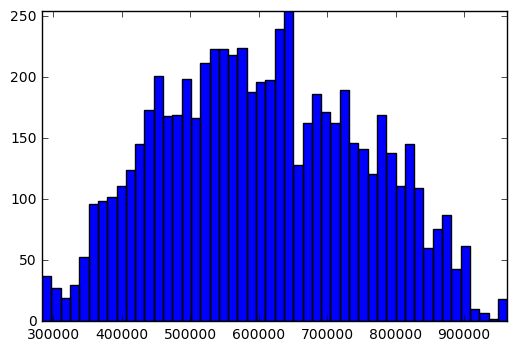

In [134]:
make_histogram(x_train['Median Sale Price'], 50)

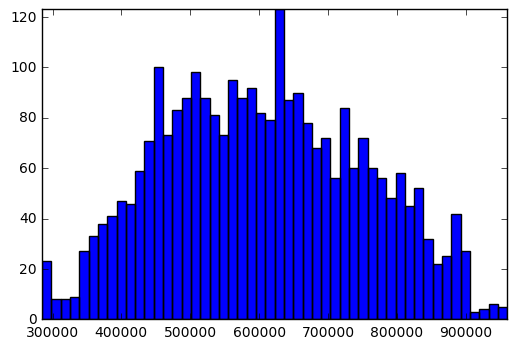

In [135]:
make_histogram(x_test['Median Sale Price'], 50)

### Decision tree classifier

In [136]:
x_train, x_test, _, _ = split_test_train(lin_reg_df, 'Median_Sale_Price_Bin')
r_forest = model(x_train, ensemble.RandomForestClassifier(n_estimators=1000), 
                 'Median_Sale_Price_Bin')

In [137]:
Y_pred, Y_test = predict(x_test, r_forest, 'Median_Sale_Price_Bin')

Normalized confusion matrix
[[ 0.536  0.389  0.074  0.   ]
 [ 0.033  0.828  0.135  0.004]
 [ 0.006  0.181  0.789  0.023]
 [ 0.006  0.142  0.5    0.352]]


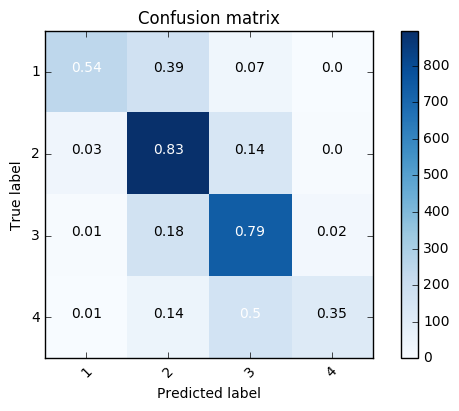

In [138]:
cm = confusion_matrix(Y_test, Y_pred)
plot_confusion_matrix(cm, np.unique(Y_pred), normalize=True)
plt.show()

The diagonal elements represent the number of points for which the predicted label is equal to the true label, while off-diagonal elements are those that are mislabeled by the classifier. The higher the diagonal values of the confusion matrix the better, indicating many correct predictions.

In [139]:
print (bins)

[ 284000.  453750.  623500.  793250.  963000.]


sums to 100 across the rows
ex: for properties within 600-800 thousand dollars, 75% were predicted correctly. But, 21% were predicted to be in the next lower price bracket.

In [140]:
x_train, x_test, _, _ = split_test_train(lin_reg_df, 'Median Sale Price')
r_forest = model(x_train, ensemble.RandomForestClassifier(max_depth=1000), 
                 'Median Sale Price')

In [141]:
Y_pred, Y_test = predict(x_test, r_forest, 'Median Sale Price')

In [142]:
for t in [0, 0.01, 0.05, 0.10, 0.15, 0.25]:
    print (evaluate(Y_pred, Y_test, t))

0.759714795009
0.759714795009
0.759714795009
0.759714795009
0.759714795009
0.759714795009
